# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2022


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2022-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0        1       2       3       4       5
  0  Christopher Street   48,024   1,692   1,357   1,255   1,133
  1           9thStreet   46,400   1,656   1,258   1,178   1,096
  2          14thStreet   86,549   3,164   2,190   2,022   2,209
  3          23rdStreet   65,503   2,584   1,320   1,115   1,642
  4          33rdStreet  265,002  10,031   6,133   5,367   6,875
  5     UPTOWN SUBTOTAL  511,478  19,127  12,258  10,937  12,955
  6                 WTC  476,823  19,225   8,498   7,789  10,883
  7   NEW YORK SUBTOTAL  988,301  38,352  20,756  18,726  23,838,
                       0          1       2       3       4       5
  0               Newark    217,316   8,924   3,461   3,269   5,191
  1             Harrison     71,183   2,905   1,185   1,094   1,689
  2       Journal Square    294,888  11,564   5,816   5,409   7,492
  3         Grove Street    186,330   6,964   4,585   3,923   4,500
  4       Exchange Place    101,427   3,999   2,051   1,784   2,273
  5

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

0          1        2       3       4       5  \
0    Christopher Street     48,024    1,692   1,357   1,255   1,133   
1             9thStreet     46,400    1,656   1,258   1,178   1,096   
2            14thStreet     86,549    3,164   2,190   2,022   2,209   
3            23rdStreet     65,503    2,584   1,320   1,115   1,642   
4            33rdStreet    265,002   10,031   6,133   5,367   6,875   
..                  ...        ...      ...     ...     ...     ...   
4        Exchange Place    187,076    7,269   3,943   2,784   3,587   
5      Pavonia/ Newport    244,243    9,270   5,647   4,001   5,343   
6               Hoboken    357,075   13,647   8,739   5,477   4,879   
7   NEW JERSEY SUBTOTAL  2,004,269   76,563  46,125  31,967  37,962   
8         MONTHLY TOTAL  3,665,979  139,597  83,597  61,925  68,765   

          date  
0   2022-01-01  
1   2022-01-01  
2   2022-01-01  
3   2022-01-01  
4   2022-01-01  
..         ...  
4   2022-12-01  
5   2022-12-01  
6   2022-12-01  
7   2022-12-01  
8   2022-12-01  

[204 rows x 7 columns]

In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

station    total  avg weekday  avg sat  avg sun  avg holiday  \
0    Christopher Street    48024         1692     1357     1255         1133   
1             9thStreet    46400         1656     1258     1178         1096   
2            14thStreet    86549         3164     2190     2022         2209   
3            23rdStreet    65503         2584     1320     1115         1642   
4            33rdStreet   265002        10031     6133     5367         6875   
..                  ...      ...          ...      ...      ...          ...   
4        Exchange Place   187076         7269     3943     2784         3587   
5      Pavonia/ Newport   244243         9270     5647     4001         5343   
6               Hoboken   357075        13647     8739     5477         4879   
7   NEW JERSEY SUBTOTAL  2004269        76563    46125    31967        37962   
8         MONTHLY TOTAL  3665979       139597    83597    61925        68765   

         month  
0   2022-01-01  
1   2022-01-01  
2   2022-01-01  
3   2022-01-01  
4   2022-01-01  
..         ...  
4   2022-12-01  
5   2022-12-01  
6   2022-12-01  
7   2022-12-01  
8   2022-12-01  

[204 rows x 7 columns]

In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

station  avg daily  total weekday  total sat  total sun  \
0    Christopher Street       1549          33830       6785       6276   
1             9thStreet       1497          33124       6290       5890   
2            14thStreet       2792          63280      10952      10108   
3            23rdStreet       2113          51685       6599       5577   
4            33rdStreet       8548         200627      30663      26837   
..                  ...        ...            ...        ...        ...   
4        Exchange Place       6035         152639      19715      11135   
5      Pavonia/ Newport       7879         194660      28235      16005   
6               Hoboken      11519         286593      43696      21907   
7   NEW JERSEY SUBTOTAL      64654        1607815     230625     127867   
8         MONTHLY TOTAL     118257        2931530     417984     247700   

    total holiday       month  
0            1133  2022-01-01  
1            1096  2022-01-01  
2            2209  2022-01-01  
3            1642  2022-01-01  
4            6875  2022-01-01  
..            ...         ...  
4            3587  2022-12-01  
5            5343  2022-12-01  
6            4879  2022-12-01  
7           37962  2022-12-01  
8           68765  2022-12-01  

[204 rows x 7 columns]

In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2022-01-01 Christopher Street        1549         1692     1357     1255   
           9thStreet                 1497         1656     1258     1178   
           14thStreet                2792         3164     2190     2022   
           23rdStreet                2113         2584     1320     1115   
           33rdStreet                8548        10031     6133     5367   
...                                   ...          ...      ...      ...   
2022-12-01 Exchange Place            6035         7269     3943     2784   
           Pavonia/ Newport          7879         9270     5647     4001   
           Hoboken                  11519        13647     8739     5477   
           NEW JERSEY SUBTOTAL      64654        76563    46125    31967   
           MONTHLY TOTAL           118257       139597    83597    61925   

                                avg holiday    total  total weekday  \
month      station                                                    
2022-01-01 Christopher Street          1133    48024          33830   
           9thStreet                   1096    46400          33124   
           14thStreet                  2209    86549          63280   
           23rdStreet                  1642    65503          51685   
           33rdStreet                  6875   265002         200627   
...                                     ...      ...            ...   
2022-12-01 Exchange Place              3587   187076         152639   
           Pavonia/ Newport            5343   244243         194660   
           Hoboken                     4879   357075         286593   
           NEW JERSEY SUBTOTAL        37962  2004269        1607815   
           MONTHLY TOTAL              68765  3665979        2931530   

                                total sat  total sun  total holiday  
month      station                                                   
2022-01-01 Christopher Street        6785       6276           1133  
           9thStreet                 6290       5890           1096  
           14thStreet               10952      10108           2209  
           23rdStreet                6599       5577           1642  
           33rdStreet               30663      26837           6875  
...                                   ...        ...            ...  
2022-12-01 Exchange Place           19715      11135           3587  
           Pavonia/ Newport         28235      16005           5343  
           Hoboken                  43696      21907           4879  
           NEW JERSEY SUBTOTAL     230625     127867          37962  
           MONTHLY TOTAL           417984     247700          68765  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

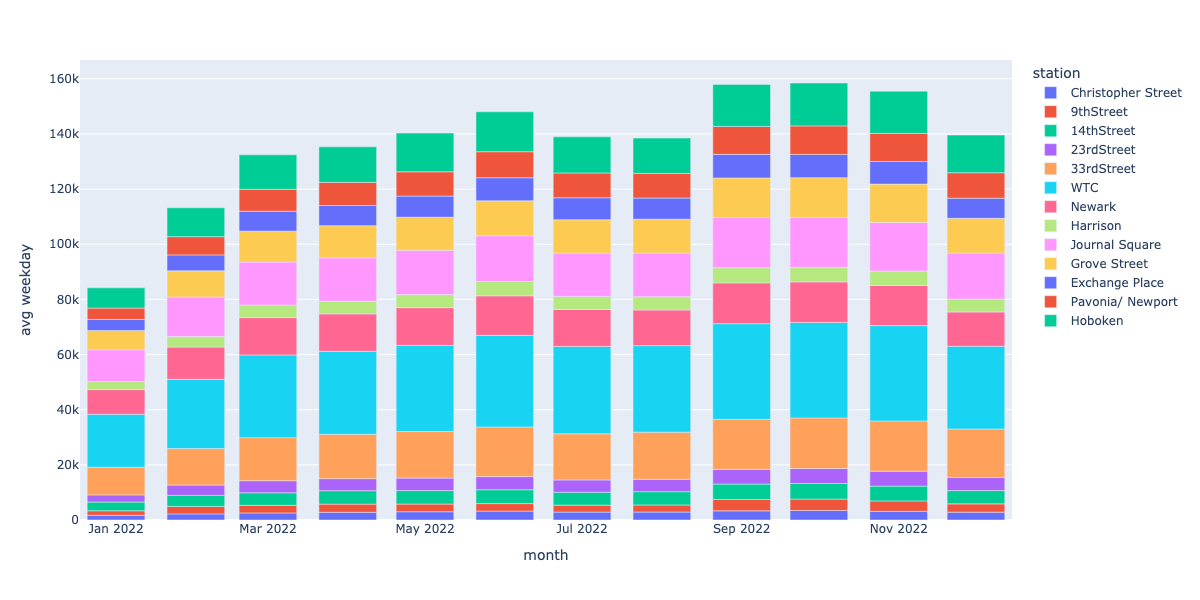

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))